In [169]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import swifter


pd.set_option('display.max_columns', None)

In [170]:
recipes = pd.read_csv('./recipes.csv')
requests = pd.read_csv('./requests.csv')
reviews = pd.read_csv('./reviews.csv')
diet = pd.read_csv('./diet.csv')

import requests as rq
url = 'https://raw.githubusercontent.com/sallto/baml/master/classify_diet.csv'
page = rq.get(url)
classify_diet = pd.DataFrame([x.split(':;') for x in page.text.split('\n')], columns = ['Ingredient', 'Diet'])[1:-1]
classify_diet

/tmp/ipykernel_427/3199781933.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv('./reviews.csv')


,Ingredient,Diet
1,Hazelnuts,Vegan
2,Broccoli florets,Vegan
3,Fresh parsley leaves,Vegan
4,Olive oil,Vegan
5,Mint leaf,Vegan
...,...,...
5010,mixed spice traditional old fashioned engli...,Vegan
5011,lady finger cookies,Vegetarian
5012,fresh thyme leave,Vegan
5013,it's a fat free pizza crust,Vegan


In [171]:
recipes['RecipeIngredientParts'] = recipes['RecipeIngredientParts'].apply(lambda x: x.replace('\\','').replace('"','').replace('c(', '').replace(')','').replace('(',''))
recipes['RecipeIngredientQuantities'] = recipes['RecipeIngredientQuantities'].apply(lambda x: x.replace('\\','').replace('"','').replace('c(', '').replace(')','').replace('(',''))

def func(x):
    res = []
    for y in x.split(','):
        y = y.strip().lower().replace('-',' ')
        found = classify_diet.loc[classify_diet['Ingredient'] == y]['Diet'].values
        if len(found) == 0:
            print(y)
            continue
        else:
            res.append(found[0])
    return res

# add meal type
classify_diet['Ingredient'] = classify_diet['Ingredient'].str.lower().str.strip().str.replace('(', '').str.replace(')', '').replace('-',' ')
recipes['RecipeIngredientParts'] = recipes['RecipeIngredientParts'].str.lower().str.strip().replace('-',' ')

#classify_diet
print(len(recipes))
recipes['DietIngredient'] = recipes['RecipeIngredientParts'].swifter.allow_dask_on_strings(enable=True).apply(func)

recipes['DietIngredient']

75604


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

0        [Vegan, Vegan, Vegan, Vegan, Vegan, Vegan, Veg...
1        [Vegetarian, Vegetarian, Vegetarian, Vegetaria...
2        [Omnivore, Vegetarian, Vegetarian, Vegan, Vege...
3        [Vegetarian, Vegetarian, Vegetarian, Vegetaria...
4        [Vegan, Vegan, Vegetarian, Vegan, Vegan, Vegan...
                               ...                        
75599    [Vegetarian, Vegan, Vegan, Vegetarian, Vegan, ...
75600    [Vegetarian, Vegan, Vegan, Vegetarian, Vegan, ...
75601    [Omnivore, Vegetarian, Vegetarian, Vegetarian,...
75602                                       [Vegan, Vegan]
75603    [Vegan, Vegan, Vegan, Vegetarian, Vegan, Veget...
Name: DietIngredient, Length: 75604, dtype: object

In [172]:
def decideDiet(x):
    if list(set(x)) == list(['Vegan']):
        return 'Vegan'
    if list(set(x)) == list(['Vegetarian']) or list(set(x)) == list(['Vegan', 'Vegetarian']):
        return 'Vegetarian'
    return 'Omnivore'


recipes['DietRecipe'] = recipes['DietIngredient'].apply(decideDiet)
recipes['DietRecipe']

0        Omnivore
1        Omnivore
2        Omnivore
3        Omnivore
4        Omnivore
           ...   
75599    Omnivore
75600    Omnivore
75601    Omnivore
75602       Vegan
75603    Omnivore
Name: DietRecipe, Length: 75604, dtype: object

In [173]:
# join recipes and requests
joined = recipes.merge(reviews, on='RecipeId', how='inner')

# join with diet
joined = joined.merge(diet, on='AuthorId', how='inner')

# join with requests
all = joined.merge(requests, on=['RecipeId', 'AuthorId'], how='inner')

In [174]:
mapping = {
    'RecipeCategory': 'string',
    'RecipeIngredientQuantities': 'string',
    'RecipeIngredientParts': 'string',
    'Name': 'string',
    'AuthorId': 'string',
    'Like': 'bool',
    'Diet': 'string',
    'HighCalories': 'bool',
    'HighProtein': 'string',
    'LowFat': 'bool',
    'LowSugar': 'string',
    'HighFiber': 'bool'
    
}
df = all.astype(mapping)

In [175]:
# add feature Rated
df['Rated'] = df['Rating'].apply(lambda x: True if x > 0 else False)

# HighProtein and LowSugar have only two values
mapping = {
    'HighProtein': 'bool',
    'LowSugar': 'bool',
}
df = df.astype(mapping)

# add feature MatchesDiet and DietCompatible
def dietComatible(row):
    diet = row['Diet']
    diet_recipe = row['DietRecipe']
    if diet == 'Vegan':
        return diet_recipe == 'Vegan'
    if diet == 'Vegetarian':
        return (diet_recipe == 'Vegan' or diet_recipe == 'Vegetarian')
    return True
df['MatchesDiet'] = df['Diet'] == df['DietRecipe']
df['DietCompatible'] = df.apply(dietComatible, axis=1)


In [176]:
print(df.groupby("Like").size())

Like
False    84503
True     55692
dtype: int64


In [177]:
def boxplot(column):
    sns.boxplot(data=df,x=df[f"{column}"])
    plt.show()

cols = ['Age', 'CookTime', 'PrepTime', 'Calories', 'FatContent', 'SaturatedFatContent', 'CarbohydrateContent', 'FiberContent', 
        'SugarContent', 'ProteinContent', 'SodiumContent', 'CholesterolContent']

#for col in cols:
    #boxplot(col)

In [178]:
mapping = {
    'Diet': 'category',
    'DietRecipe': 'category',
    'RecipeCategory': 'category',
    'DietCompatible': 'bool',
    'MatchesDiet': 'bool',
}
df = df.astype(mapping)
df = pd.get_dummies(df, columns=['Diet', 'DietRecipe', 'RecipeCategory'])

In [179]:
df['RecipeServings'].fillna(1, inplace=True)

df['TimePerServing'] = df['CookTime'] / df['RecipeServings']
df['TotalTime'] = df['CookTime'] + df['PrepTime']
df['TotalTimePerServing'] =  df['TotalTime'] / df['RecipeServings']
df['CaloriesPerServing'] = df['Calories'] / df['RecipeServings']
df['ProteinFatRatio'] = df['ProteinContent'] / (df['FatContent']+0.000001)
df['RequestedTimeRatio'] = df['Time'] / (df['TotalTime']+0.000001)

df['isInTime'] = df['TotalTime'] <= df['Time']

df['NumberIngredients'] = df['RecipeIngredientParts'].apply(lambda x: len(x.split(',')))

def getRecipePopularity(row):
    recipe_id = row['RecipeId']
    return len(df.loc[(df['RecipeId'] == recipe_id) & (df['Like'] == True)])

df['RecipePopularity'] = df.swifter.allow_dask_on_strings(enable=True).apply(getRecipePopularity, axis=1)
df['RecipePopularity'].fillna(0, inplace=True)

df['RequestedIngredientCount'] = df['RecipeIngredientQuantities'].apply(lambda x: len(x.split(',')))
df['IngredientCountMatches'] = df['NumberIngredients'] == df['RequestedIngredientCount']


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [180]:
df['AvgRecipePopularity'] = df.swifter.allow_dask_on_strings(enable=True).apply(lambda row: row['RecipePopularity'] / len(df.loc[df['RecipeId'] == row['RecipeId']]), axis=1)
df['AvgRecipePopularity']

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

0         0.422018
1         1.000000
2         0.422018
3         0.363636
4         0.422018
            ...   
140190    1.000000
140191    1.000000
140192    1.000000
140193    1.000000
140194    1.000000
Name: AvgRecipePopularity, Length: 140195, dtype: float64

In [181]:
""" df['AuthorRecipeCount'] = df.swifter.allow_dask_on_strings(enable=True).apply(lambda row: len(df.loc[df['AuthorId'] == row['AuthorId']]), axis=1)
df['AuthorRecipeCount'] """

df['AuthorFrequency'] = df.groupby('AuthorId')['AuthorId'].transform('count')
df['RecipeFrequency'] = df.groupby('RecipeId')['RecipeId'].transform('count')
df['AuthorFrequency']

0         2
1         2
2         2
3         2
4         1
         ..
140190    1
140191    1
140192    1
140193    1
140194    1
Name: AuthorFrequency, Length: 140195, dtype: int64

In [182]:
bins = [0, 18, 24, 34, 44, 54, 64, 100]
labels = ['0-18', '19-24', '25-34', '35-44', '45-54', '55-64', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)
df = pd.get_dummies(df, columns=['AgeGroup'])

#df['TimePerServing']


Until here all feature engineering stuff must be done

We can see some outlier which we will remove

In [183]:
# takes around 3 minutes
print(list(df))
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numeric_cols = ['Age', 'CookTime', 'PrepTime', 'Calories', 'FatContent', 'SaturatedFatContent', 'CarbohydrateContent', 'FiberContent', 
        'SugarContent', 'ProteinContent', 'SodiumContent', 'CholesterolContent', 'TimePerServing','TotalTime','TotalTimePerServing','CaloriesPerServing', 'ProteinFatRatio'
        , 'RequestedTimeRatio', 'NumberIngredients']
df_lof = df[numeric_cols]

scaler = StandardScaler()
df_lof = scaler.fit_transform(df_lof)

clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(df_lof)
X_scores = clf.negative_outlier_factor_

df['Outlier'] = y_pred

['RecipeId', 'Name', 'CookTime', 'PrepTime', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeYield', 'DietIngredient', 'AuthorId', 'Rating', 'Like', 'TestSetId', 'Age', 'Time', 'HighCalories', 'HighProtein', 'LowFat', 'LowSugar', 'HighFiber', 'Rated', 'MatchesDiet', 'DietCompatible', 'Diet_Omnivore', 'Diet_Vegan', 'Diet_Vegetarian', 'DietRecipe_Omnivore', 'DietRecipe_Vegan', 'DietRecipe_Vegetarian', 'RecipeCategory_Beverages', 'RecipeCategory_Bread', 'RecipeCategory_Breakfast', 'RecipeCategory_Lunch', 'RecipeCategory_One dish meal', 'RecipeCategory_Other', 'RecipeCategory_Soup', 'TimePerServing', 'TotalTime', 'TotalTimePerServing', 'CaloriesPerServing', 'ProteinFatRatio', 'RequestedTimeRatio', 'isInTime', 'NumberIngredients', 'RecipePopularity', 'RequestedIngredientCount', 'IngredientCountMatches

In [184]:
from sklearn.ensemble import IsolationForest

df_lof = df[numeric_cols]
clf = IsolationForest(random_state=0).fit(df_lof)
y_pred = clf.fit_predict(df_lof)

#df['Outlier'] = y_pred

In [185]:
train_all = df[df['TestSetId'].isna()]
test = df[df['TestSetId'].notna()]
print(len(train_all))
print(len(test))
test[test['TestSetId'].isna()]

97381
42814


,RecipeId,Name,CookTime,PrepTime,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,DietIngredient,AuthorId,Rating,Like,TestSetId,Age,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber,Rated,MatchesDiet,DietCompatible,Diet_Omnivore,Diet_Vegan,Diet_Vegetarian,DietRecipe_Omnivore,DietRecipe_Vegan,DietRecipe_Vegetarian,RecipeCategory_Beverages,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,TimePerServing,TotalTime,TotalTimePerServing,CaloriesPerServing,ProteinFatRatio,RequestedTimeRatio,isInTime,NumberIngredients,RecipePopularity,RequestedIngredientCount,IngredientCountMatches,AvgRecipePopularity,AuthorFrequency,RecipeFrequency,AgeGroup_0-18,AgeGroup_19-24,AgeGroup_25-34,AgeGroup_35-44,AgeGroup_45-54,AgeGroup_55-64,AgeGroup_65+,Outlier


In [186]:
threshold = -10
#outlier = train_all[train_all['Outlier'] < threshold]
outlier = train_all[train_all['Outlier'] == -1]
print(len(outlier))
outlier['Name'].unique()

2022


<StringArray>
[                                    'Apricot Honey Syrup',
                                     'Marinated Mushrooms',
                              'South American Steak Sauce',
         'Rack of Pork With Ginger Cooked in a Salt Crust',
                    'Gooseberry and Elderflower Ice Cream',
                          'Balsamic Pot Roast (Crock Pot)',
                                          'Dandelion Wine',
                                  'Cold Pressed Ox Tongue',
                               'Simply Healthy Veal Jerky',
                                         'Italian Sausage',
 ...
               'Chicken and Liege Waffles With Herb Gravy',
                                   'Chicken Sauce Piquant',
                                           'Chicken Salad',
                          'Mile High FudgeTopped Brownies',
                                      'Coconut Cream Cake',
                                        'Sriracha Ketchup',
                     

In [187]:
#train_all = train_all[train_all['Outlier'] >= threshold]
train_all = train_all[train_all['Outlier'] == 1]
print(len(train_all))
train_all.head()

95359


,RecipeId,Name,CookTime,PrepTime,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,DietIngredient,AuthorId,Rating,Like,TestSetId,Age,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber,Rated,MatchesDiet,DietCompatible,Diet_Omnivore,Diet_Vegan,Diet_Vegetarian,DietRecipe_Omnivore,DietRecipe_Vegan,DietRecipe_Vegetarian,RecipeCategory_Beverages,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,TimePerServing,TotalTime,TotalTimePerServing,CaloriesPerServing,ProteinFatRatio,RequestedTimeRatio,isInTime,NumberIngredients,RecipePopularity,RequestedIngredientCount,IngredientCountMatches,AvgRecipePopularity,AuthorFrequency,RecipeFrequency,AgeGroup_0-18,AgeGroup_19-24,AgeGroup_25-34,AgeGroup_35-44,AgeGroup_45-54,AgeGroup_55-64,AgeGroup_65+,Outlier
163,73440,Bow Ties With Broccoli Pesto,0,1800,"6, 2, 1 1/2, 1/4, 1/2, 4, 1 1/2, 1 1/2, 5, 12","hazelnuts, broccoli florets, fresh parsley lea...",241.3,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,9.0,NaN,"[Vegan, Vegan, Vegan, Vegan, Vegan, Vegan, Veg...",1073154D,2.0,False,NaN,59,1799.844169,False,True,True,True,True,True,False,False,0,0,1,1,0,0,0,0,0,0,0,1,0,0.0,1800,200.0,26.811111,0.663366,0.999913,False,10,46,10,True,0.422018,50,109,0,0,0,0,0,1,0,1
164,214973,Carne Guisada (Stewed Beef),3000,1200,"2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1","beef round steak, onion, green pepper, garlic ...",331.6,18.9,6.2,92.3,235.8,5.7,1.4,2.6,33.4,1.0,NaN,"[Omnivore, Vegetarian, Vegetarian, Vegan, Vege...",1073154D,2.0,False,NaN,59,4200.065436,True,True,False,True,False,True,False,False,0,0,1,1,0,0,0,0,0,0,0,1,0,3000.0,4200,4200.0,331.600000,1.767196,1.000016,True,13,1,14,False,0.500000,50,2,0,0,0,0,0,1,0,1
165,87925,Veggie Puff Pastries,2400,1500,"1, 1, 1/2, 3 1/2, 2, 1, 1, 2, 1, 1, 1","puff pastry, egg, sweet potato, asparagus spea...",775.0,50.4,15.0,68.1,405.1,69.8,5.0,6.1,12.1,4.0,NaN,"[Vegetarian, Omnivore, Vegan, Vegan, Vegetaria...",1073154D,2.0,False,NaN,59,3900.449168,True,True,True,True,True,True,False,False,0,0,1,1,0,0,0,0,0,0,0,1,0,600.0,3900,975.0,193.750000,0.240079,1.000115,True,11,7,11,True,0.280000,50,25,0,0,0,0,0,1,0,1
166,111514,Delicious Fluffy Pancakes,1500,300,"1 1/2, 1 1/2, 1, 1 1/4, 3, 1, 2","flour, baking powder, salt, milk, butter, egg,...",170.6,6.6,3.8,43.2,553.5,23.5,0.6,3.3,4.5,1.0,8 pancakes,"[Vegetarian, Vegetarian, Vegan, Vegetarian, Ve...",1073154D,2.0,False,NaN,59,1800.542375,True,True,False,True,False,True,False,False,0,0,1,1,0,0,0,0,1,0,0,0,0,1500.0,1800,1800.0,170.600000,0.681818,1.000301,True,7,9,7,True,0.290323,50,31,0,0,0,0,0,1,0,1
167,8782,Garden Chicken,2100,1500,"4, 1, 5, 1, 1, 1, 4, 1, 1/2, 1/2, 2, 1, 1, 1, 1/3","boneless skinless chicken breast halves, garli...",436.2,19.1,10.6,95.6,501.4,37.3,2.2,3.2,27.8,6.0,1 casserole,"[Omnivore, Vegetarian, Vegetarian, Vegetarian,...",1073154D,NaN,False,NaN,59,3601.194876,True,True,False,True,True,False,False,False,0,0,1,1,0,0,0,0,0,0,0,1,0,350.0,3600,600.0,72.700000,1.455497,1.000332,True,13,20,15,False,0.606061,50,33,0,0,0,0,0,1,0,1


In [188]:
print(train_all.groupby("Like").size())

Like
False    82802
True     12557
dtype: int64


In [189]:
""" import matplotlib.pyplot as plt
%matplotlib inline

for col in numeric_cols:
    plt.hist(train_all[col], density=True, bins=30)  # density=False would make counts
    plt.ylabel('Probability')
    plt.xlabel(col)
    plt.show() """

" import matplotlib.pyplot as plt\n%matplotlib inline\n\nfor col in numeric_cols:\n    plt.hist(train_all[col], density=True, bins=30)  # density=False would make counts\n    plt.ylabel('Probability')\n    plt.xlabel(col)\n    plt.show() "

In [190]:
train_all.describe()

,RecipeId,CookTime,PrepTime,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,Rating,TestSetId,Age,Time,Diet_Omnivore,Diet_Vegan,Diet_Vegetarian,DietRecipe_Omnivore,DietRecipe_Vegan,DietRecipe_Vegetarian,RecipeCategory_Beverages,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,TimePerServing,TotalTime,TotalTimePerServing,CaloriesPerServing,ProteinFatRatio,RequestedTimeRatio,NumberIngredients,RecipePopularity,RequestedIngredientCount,AvgRecipePopularity,AuthorFrequency,RecipeFrequency,AgeGroup_0-18,AgeGroup_19-24,AgeGroup_25-34,AgeGroup_35-44,AgeGroup_45-54,AgeGroup_55-64,AgeGroup_65+,Outlier
count,95359.000000,9.535900e+04,9.535900e+04,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,52262.0,0.0,95359.000000,9.535900e+04,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,9.535900e+04,9.535900e+04,9.535900e+04,95359.000000,9.535900e+04,9.535900e+04,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.000000,95359.0
mean,151733.554054,4.648875e+03,2.133139e+03,470.427655,23.805230,9.244427,84.298620,710.000019,47.800689,3.737243,21.227975,17.142878,5.538428,2.0,NaN,47.476767,6.784054e+03,0.107415,0.050399,0.842186,0.926247,0.046141,0.027611,0.028094,0.055642,0.039965,0.063423,0.062543,0.748057,0.002276,2.990032e+03,6.782014e+03,4.145872e+03,298.489636,2.192266e+03,2.180994e+06,7.978544,3.432177,8.818675,0.252863,47.033327,9.237628,0.023983,0.110729,0.158653,0.166015,0.154763,0.160897,0.224960,1.0
std,129631.082359,9.686093e+04,3.380990e+04,659.843962,41.041277,17.661349,143.432934,2292.784067,85.742934,5.598980,58.640343,21.247633,9.957818,0.0,NaN,18.142267,1.065636e+05,0.309642,0.218768,0.364569,0.261370,0.209792,0.163858,0.165242,0.229231,0.195877,0.243724,0.242140,0.434131,0.047649,9.557375e+04,1.065637e+05,1.047922e+05,670.859705,5.263976e+04,1.455647e+08,3.983749,10.442043,3.948593,0.293175,83.999263,23.778362,0.152997,0.313798,0.365354,0.372096,0.361680,0.367438,0.417558,0.0
min,40.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.0,NaN,18.000000,-2.606528e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,-2.606528e+06,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,46648.000000,6.000000e+02,6.000000e+02,177.100000,5.700000,1.500000,4.800000,125.050000,13.100000,0.900000,2.500000,3.500000,1.000000,2.0,NaN,32.000000,1.201265e+03,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+02,1.200000e+03,3.000000e+02,36.625000,3.333333e-01,9.997348e-01,5.000000,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,108775.000000,1.200000e+03,9.000000e+02,318.500000,13.700000,4.700000,44.000000,353.300000,28.400000,2.200000,6.500000,9.200000,4.000000,2.0,NaN,47.000000,2.399575e+03,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000e+02,2.400000e+03,6.000000e+02,94.866667,7.960199e-01,1.000001e+00,8.000000,1.000000,8.000000,0.200000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,230109.500000,2.700000e+03,1.200000e+03,528.800000,27.300000,10.800000,108.600000,794.800000,50.800000,4.500000,17.800000,25.200000,6.000000,2.0,Na

The class labels are uneven distributed. Therefore, we sample only a part of the False Like labels

In [191]:
""" false_sample = train_all[train_all['Like'] == False].sample(frac=0.9, random_state=1)
true_sample = train_all[train_all['Like'] == True]
true_sample = pd.concat([true_sample] * 6)

train_all = pd.concat([false_sample, true_sample])
print(len(train_all))
print(train_all.groupby("Like").size()) """



' false_sample = train_all[train_all[\'Like\'] == False].sample(frac=0.9, random_state=1)\ntrue_sample = train_all[train_all[\'Like\'] == True]\ntrue_sample = pd.concat([true_sample] * 6)\n\ntrain_all = pd.concat([false_sample, true_sample])\nprint(len(train_all))\nprint(train_all.groupby("Like").size()) '

In [224]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


""" 

"""

X_cols = [
 'CookTime',
 'PrepTime',
 'Calories',
 'FatContent',
 'SaturatedFatContent',
 'CholesterolContent',
 'SodiumContent',
 'CarbohydrateContent',
 'FiberContent',
 'SugarContent',
 'ProteinContent',
 'Age',
 'Time',
 'HighCalories',
 'HighProtein',
 'LowFat',
 'LowSugar',
 'HighFiber',
 'Rated',

 'MatchesDiet',
 'DietCompatible',
 
 'AgeGroup_0-18', 
 'AgeGroup_19-24', 
 'AgeGroup_25-34', 
 'AgeGroup_35-44', 
 'AgeGroup_45-54', 
 'AgeGroup_55-64', 
 'AgeGroup_65+',

 'Diet_Omnivore',
 'Diet_Vegan',
 'Diet_Vegetarian',
 'DietRecipe_Omnivore',
 'DietRecipe_Vegan',
 'DietRecipe_Vegetarian',
 'RecipeCategory_Beverages',
 'RecipeCategory_Bread',
 'RecipeCategory_Breakfast',
 'RecipeCategory_Lunch',
 'RecipeCategory_One dish meal',
 'RecipeCategory_Other',
 'RecipeCategory_Soup',

 'NumberIngredients',

 'RecipePopularity',

 'AvgRecipePopularity',

 'AuthorFrequency',
 'RecipeFrequency',

 'IngredientCountMatches',

 'TimePerServing','TotalTime','TotalTimePerServing','CaloriesPerServing','ProteinFatRatio','RequestedTimeRatio'
 ]

X = train_all[X_cols]
y = train_all['Like']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

In [225]:
print(pd.DataFrame(y_train, columns=['Like']).groupby("Like").size())
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(pd.DataFrame(y_train, columns=['Like']).groupby("Like").size())

Like
False    55477
True      8413
dtype: int64
Like
False    55477
True     55477
dtype: int64


In [226]:
""" from imblearn.over_sampling import RandomOverSampler
print(pd.DataFrame(y_train, columns=['Like']).groupby("Like").size())
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

print(pd.DataFrame(y_train, columns=['Like']).groupby("Like").size()) """

' from imblearn.over_sampling import RandomOverSampler\nprint(pd.DataFrame(y_train, columns=[\'Like\']).groupby("Like").size())\noversampler = RandomOverSampler(random_state=42)\nX_train, y_train = oversampler.fit_resample(X_train, y_train)\n\nprint(pd.DataFrame(y_train, columns=[\'Like\']).groupby("Like").size()) '

In [227]:
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
decision_tree = tree.DecisionTreeClassifier()
clf = decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_val)


print(classification_report(y_val, y_pred))
print(balanced_accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.95      0.93      0.94     27325
        True       0.62      0.69      0.65      4144

    accuracy                           0.90     31469
   macro avg       0.78      0.81      0.80     31469
weighted avg       0.91      0.90      0.90     31469

0.8100274253144792


In [242]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform a grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='balanced_accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(best_params)



KeyboardInterrupt: 

In [248]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

rf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=300)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)


print(classification_report(y_val, y_pred))
print(balanced_accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.89      0.93     27325
        True       0.55      0.83      0.66      4144

    accuracy                           0.89     31469
   macro avg       0.76      0.86      0.80     31469
weighted avg       0.92      0.89      0.90     31469

0.864410079763465


Feature ranking:
AvgRecipePopularity: 0.38808205070166757
RecipePopularity: 0.2253378347573255
Age: 0.08599434223881441
AgeGroup_25-34: 0.04665721130372233
AgeGroup_19-24: 0.03400858420048335
AgeGroup_35-44: 0.027081624152702957
AgeGroup_45-54: 0.022112719477230713
RecipeFrequency: 0.021025336403648575
Diet_Vegetarian: 0.01684439628659813
DietCompatible: 0.014349115892613446
Rated: 0.013791952007009518
AgeGroup_55-64: 0.010016888604113318
MatchesDiet: 0.009924455370435249
LowFat: 0.009618869304572609
Diet_Omnivore: 0.009130960152450735
HighFiber: 0.008182328938183738
ProteinContent: 0.005054223784335854
CarbohydrateContent: 0.004790548891545585
Calories: 0.0043716157960754405
FiberContent: 0.004051652268461962
FatContent: 0.0036374392524890025
RecipeCategory_Other: 0.0033404243178389898
SugarContent: 0.0031442453854688976
AuthorFrequency: 0.0031244873260373946
IngredientCountMatches: 0.0025685875780207803
ProteinFatRatio: 0.002312761364585302
Diet_Vegan: 0.002230867015295342
RecipeCate

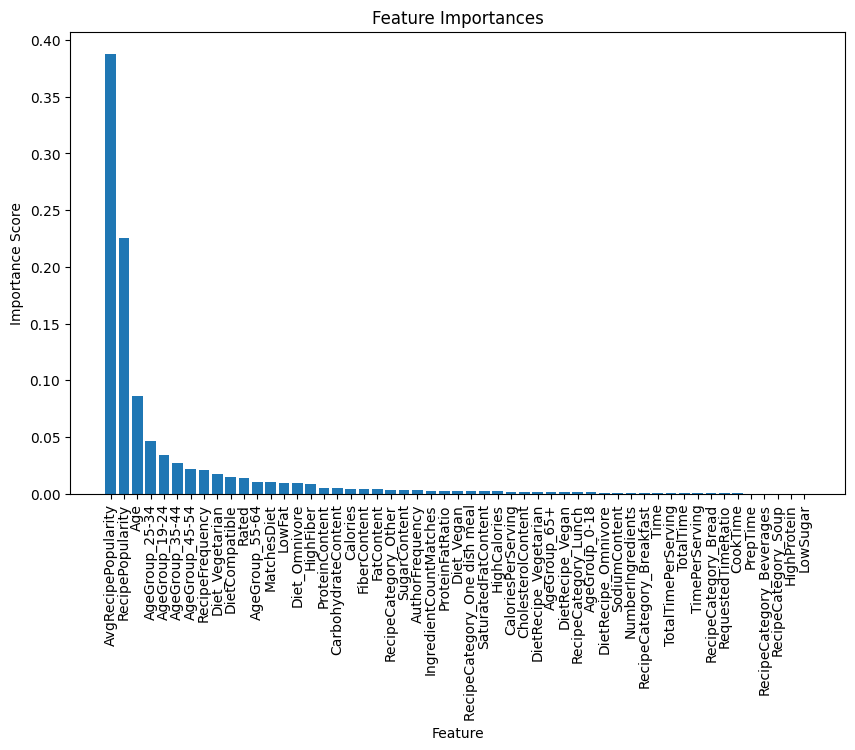

In [250]:
import numpy as np
# Get feature importances
feature_importances = rf.feature_importances_

# Get the indices of the features in descending order of importance
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {feature_importances[indices[f]]}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [229]:
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

count_positive = len(train_all[train_all['Like'] == 1])
count_negative = len(train_all[train_all['Like'] == 0])
scale_pos_weight = count_negative / count_positive 
scale_pos_weight = 1
print(scale_pos_weight)

#Creating an XGBoost classifier
xgboost_only = xgb.XGBClassifier(scale_pos_weight = scale_pos_weight)

#Training the model on the training data
xgboost_only.fit(X_train, y_train)

#Making predictions on the test set
predictions = xgboost_only.predict(X_val)

print(classification_report(y_val, predictions))
print(balanced_accuracy_score(y_val, predictions))
#0.9413489394190455
#0.9427678583094481
#0.8855812391596929

1
              precision    recall  f1-score   support

       False       0.96      0.97      0.96     27325
        True       0.80      0.71      0.75      4144

    accuracy                           0.94     31469
   macro avg       0.88      0.84      0.86     31469
weighted avg       0.94      0.94      0.94     31469

0.8422491937107675


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

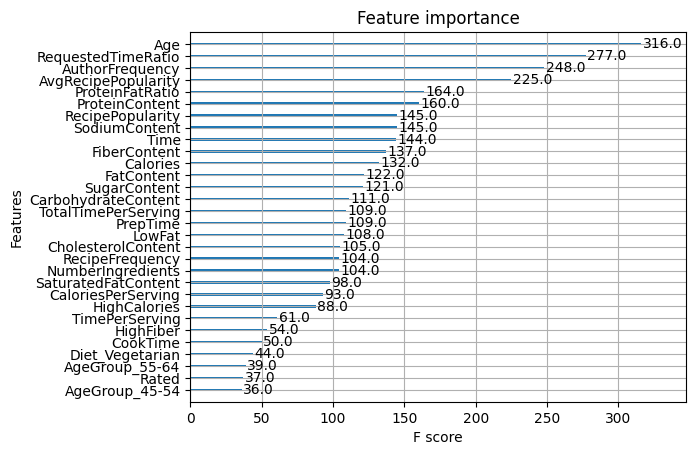

In [230]:
xgb.plot_importance(xgboost_only, max_num_features = 30)

In [231]:
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb
from sklearn.metrics import classification_report

xgboost = xgb.XGBClassifier()
bagging_clf = BaggingClassifier(estimator = xgboost, n_estimators=30, random_state=0, max_samples = 0.7, oob_score = True).fit(X_train, y_train)
predictions = bagging_clf.predict(X_val)

print(bagging_clf.oob_score_)
print(classification_report(y_val, predictions))
print(balanced_accuracy_score(y_val, predictions))
#0.9587725853231339

0.9656614452836311
              precision    recall  f1-score   support

       False       0.96      0.98      0.97     27325
        True       0.81      0.70      0.75      4144

    accuracy                           0.94     31469
   macro avg       0.88      0.84      0.86     31469
weighted avg       0.94      0.94      0.94     31469

0.8399835739542967


In [232]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler


scaler = StandardScaler()
X_train_stand = scaler.fit_transform(X_train)
X_val_stand = scaler.fit_transform(X_val)

knn_model = KNeighborsClassifier(n_neighbors=200, weights = 'distance')
#Training the model on the training data
knn_model.fit(X_train_stand, y_train)

#Making predictions on the test set
predictions = knn_model.predict(X_val_stand)

print(classification_report(y_val, predictions))
print(balanced_accuracy_score(y_val, predictions))

              precision    recall  f1-score   support

       False       0.96      0.89      0.92     27325
        True       0.51      0.73      0.60      4144

    accuracy                           0.87     31469
   macro avg       0.73      0.81      0.76     31469
weighted avg       0.90      0.87      0.88     31469

0.8130127796401813


In [233]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier(max_depth=2)
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42, estimator=decision_tree)

#Training the model on the training data
adaboost_model.fit(X_train, y_train)

#Making predictions on the test set
predictions = adaboost_model.predict(X_val)

print(classification_report(y_val, predictions))
print(balanced_accuracy_score(y_val, predictions))
#0.9106066772690254

              precision    recall  f1-score   support

       False       0.96      0.97      0.96     27325
        True       0.78      0.73      0.75      4144

    accuracy                           0.94     31469
   macro avg       0.87      0.85      0.86     31469
weighted avg       0.93      0.94      0.94     31469

0.8471978579023409


In [236]:
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline


random_forest = RandomForestClassifier(max_depth=5, random_state=0)
decision_tree = tree.DecisionTreeClassifier()
xgboost = xgb.XGBClassifier()
knn_model = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=200))])


eclf = VotingClassifier(estimators=[('xgboost', xgboost), ('dt', decision_tree), ('knn', knn_model), ('adaboost', adaboost_model), ('rf', random_forest)], voting='hard')

#Training the model on the training data
eclf.fit(X_train, y_train)

#Making predictions on the test set
predictions = eclf.predict(X_val)

print(classification_report(y_val, predictions))
print(balanced_accuracy_score(y_val, predictions))
#0.9665586708637973

              precision    recall  f1-score   support

       False       0.96      0.97      0.96     27325
        True       0.78      0.71      0.74      4144

    accuracy                           0.94     31469
   macro avg       0.87      0.84      0.85     31469
weighted avg       0.93      0.94      0.93     31469

0.8401237207996128


## Save predictions as file

In [235]:
# train with all data
final_model = eclf
final_model = final_model.fit(X, y)
predictions_final = final_model.predict(test[X_cols])

df_final = pd.DataFrame()
df_final['id'] = test['TestSetId']
df_final['prediction'] = predictions_final

df_final['id'] = df_final['id'].astype(int)
df_final['prediction'] = df_final['prediction'].astype(int)

df_final.to_csv('predictions.csv', index=False)
df_final

KeyboardInterrupt: 